# Golden Cross / Death Cross S&P 500 index (^GSPC)

    1. sma50>sma200, buy
    2. sma50<sma200, sell your long position.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = '^GSPC'
symbol = 'SPY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()
use_adj=True

Prepare timeseries

In [4]:
# fetch and select timeseries
ts = pf.fetch_timeseries(symbol,)
ts = pf.select_tradeperiod(ts, start, end, use_adj=use_adj)

# Add technical indicator: day sma regime filter
ts['regime'] = \
    pf.CROSSOVER(ts, timeperiod_fast=50, timeperiod_slow=200)

# Finalize the time series before implementing trading strategy
ts, start = pf.finalize_timeseries(ts, start)

# Create Trade Log (tlog); Create Daily Balance (dbal)
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [5]:
pf.TradeLog.cash = capital

for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high; low = row.low; close = row.close; 
    end_flag = pf.is_last_row(ts, i)

    # buy
    if tlog.shares == 0:
        if row.regime > 0 and ts['regime'][i-1] < 0:
            tlog.buy(date, close)  
    # sell
    else:
        if row.regime < 0 or end_flag:
            tlog.sell(date, close)

    # record daily balance
    dbal.append(date, high, low, close)       

Retrieve logs

In [6]:
tlog = tlog.get_log()
dbal = dbal.get_log(tlog)

Generate strategy stats - display all available stats

In [7]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   1993-11-11
end                                                     2021-03-26
beginning_balance                                            10000
ending_balance                                           122227.54
total_net_profit                                         112227.54
gross_profit                                             126143.83
gross_loss                                               -13916.29
profit_factor                                                 9.06
return_on_initial_capital                                  1122.28
annual_return_rate                                            9.58
trading_period                           27 years 4 months 15 days
pct_time_in_market                                           74.74
margin                                                           1
avg_leverage                                                  1.00
max_leverage                                                  

Benchmark: Run, retrieve logs, generate stats

In [8]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj=use_adj)
benchmark.run()

Plot Equity Curves: Strategy vs Benchmark

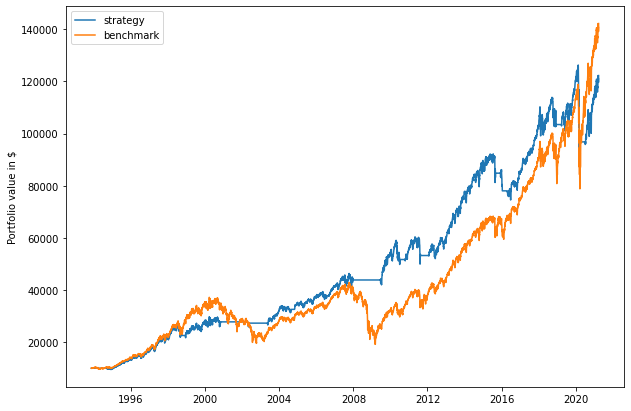

In [9]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

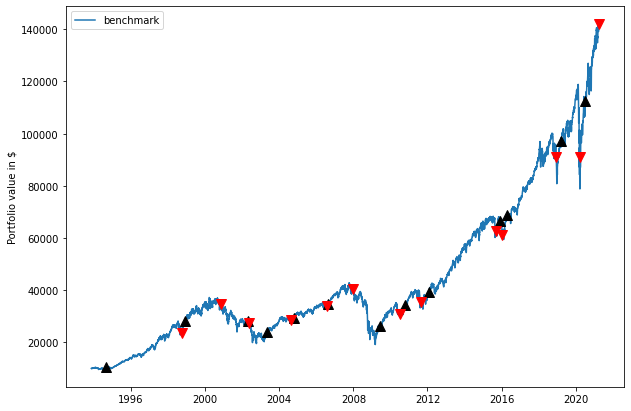

In [10]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Strategy vs Benchmark

In [11]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$122,227.54","$142,170.90"
total_net_profit,"$112,227.54","$132,170.90"
gross_profit,"$126,143.83","$132,170.90"
gross_loss,"-$13,916.29",$0.00


,strategy,benchmark
annual_return_rate,9.58,10.18
max_closed_out_drawdown,-33.68,-55.17
annualized_return_over_max_drawdown,0.28,0.18
best_month,15.58,23.60
worst_month,-30.95,-30.98
sharpe_ratio,0.73,0.60
sortino_ratio,0.78,0.77
monthly_std,3.27,4.52
annual_std,12.02,16.91
avg_month,0.78,0.87


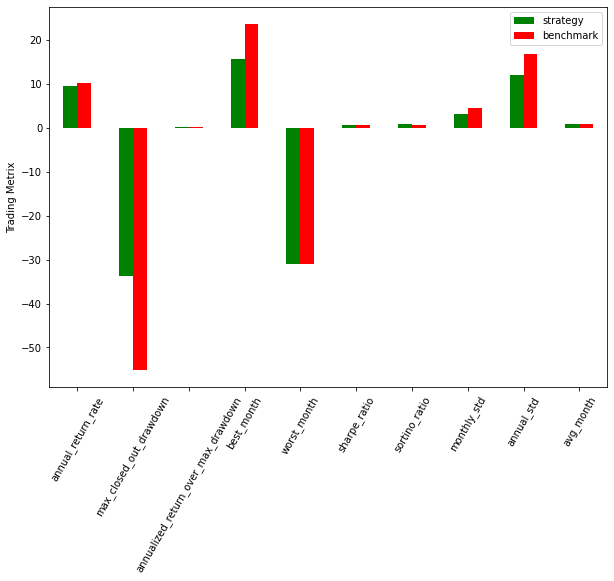

In [12]:
extras = ('avg_month',)

df = pf.plot_bar_graph(stats, benchmark.stats, extras=extras)
df